### В данном исследовании проводится исследование процессов, происходящих в полиэтиленовом поршне при различных параметрах

![](nu.jpg)

In [1]:
import os
wd = os.getcwd()
wd = os.path.dirname(os.path.dirname(wd))
import sys
sys.path.append(wd+"\\src\\")

In [2]:
from math import *

from tube import InterpXY,Tube
import numpy as np
from pistonlayer import ElPistEOS, ElPistLayer
import pprint as pp

def my_imports():
    from tube import InterpXY,Tube
    import numpy as np
    from pistonlayer import ElPistEOS, ElPistLayer
    import pprint as pp
my_imports()

In [3]:
from tqdm import tqdm_notebook
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets

%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (5,3) 

In [4]:
from dask.distributed import Client
import dask

# cl = Client('172.16.50.134:8786')
cl = Client(threads_per_worker=1)
cl

Client Scheduler: tcp://127.0.0.1:31708 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 12 Memory: 17.05 GB


In [5]:
# функция для импорта в кластере
def path_add(foo):
    def inner(*args, **kwargs):
        import sys
        dirs = ["D:\\.cluster\\src\\", "E:\\.cluster\\src\\"]
        for d in dirs:
            while d in sys.path:
                sys.path.remove(d)
            sys.path.append(d)
        return foo(*args, **kwargs)
    return inner

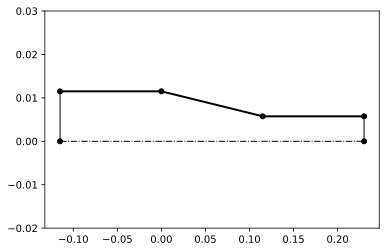

In [6]:
# {
#     'D_1': 23, #мм
#     'D2_D1': 0.5 # отношение
#     'L_D1': 5, # тоже самое
# }

def get_tube(**kw):
    from tube import InterpXY,Tube
    import numpy as np
    from pistonlayer import ElPistEOS, ElPistLayer
    import pprint as pp
    D_1 = kw.get('D_1', 23) * 1e-3 # D_1, mm
    D2_D1 = kw.get('D2_D1', 0.5)
    D_2 = D_1 * D2_D1
    L_D1 = kw.get('L_D1', 5)
    L = D_1 * L_D1
    tube_dict = {
        'tube_points': [[-L,D_1],[0, D_1],[L,D_2],[2*L, D_2]]
    }
    tube = Tube.get_standart(tube_dict)
    return tube

tube = get_tube()
ax, fig = plt.subplots()
tube.plot(ax, fig)
fig.set_ylim(-0.02, 0.03)
# fig.set_xlim(-6*d,d)
plt.show()

In [7]:
@path_add
def tsty(a):
    tube2 = get_tube()
    return str(tube2)

In [8]:
futs = [cl.submit(tsty, i) for i in range(130)]
cl.gather(futs)

['Tube(xs=[-0.11499999999999999, 0.0, 0.11499999999999999, 0.22999999999999998], ds=[0.023, 0.023, 0.0115, 0.0115])',
 'Tube(xs=[-0.11499999999999999, 0.0, 0.11499999999999999, 0.22999999999999998], ds=[0.023, 0.023, 0.0115, 0.0115])',
 'Tube(xs=[-0.11499999999999999, 0.0, 0.11499999999999999, 0.22999999999999998], ds=[0.023, 0.023, 0.0115, 0.0115])',
 'Tube(xs=[-0.11499999999999999, 0.0, 0.11499999999999999, 0.22999999999999998], ds=[0.023, 0.023, 0.0115, 0.0115])',
 'Tube(xs=[-0.11499999999999999, 0.0, 0.11499999999999999, 0.22999999999999998], ds=[0.023, 0.023, 0.0115, 0.0115])',
 'Tube(xs=[-0.11499999999999999, 0.0, 0.11499999999999999, 0.22999999999999998], ds=[0.023, 0.023, 0.0115, 0.0115])',
 'Tube(xs=[-0.11499999999999999, 0.0, 0.11499999999999999, 0.22999999999999998], ds=[0.023, 0.023, 0.0115, 0.0115])',
 'Tube(xs=[-0.11499999999999999, 0.0, 0.11499999999999999, 0.22999999999999998], ds=[0.023, 0.023, 0.0115, 0.0115])',
 'Tube(xs=[-0.11499999999999999, 0.0, 0.1149999999999999

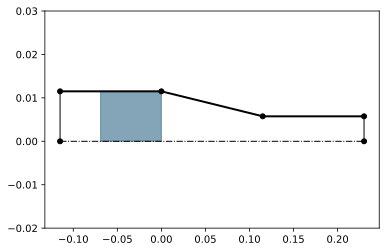

In [9]:
# {
#     'D_1': 23, #мм
#     'D2_D1': 0.5 # отношение
#     'L_D1': 5, # тоже самое
#    'L_pist_D1': 3
# }

def get_pl(**kw):
    """
        'D1', 23
        'D2_D1', 0.5
        'L_D1', 5
        'M', 1.5        * 2308
        'L_pist_D1', 3
        'P_2', 1        * 1e5
                
    """
    D_1 = kw.get('D1', 23) * 1e-3 # D_1, mm
    D2_D1 = kw.get('D2_D1', 0.5)
    D_2 = D_1 * D2_D1
    L_D1 = kw.get('L_D1', 5)
    L = D_1 * L_D1
    tube_dict = {
        'tube_points': [[-L,D_1],[0, D_1],[L,D_2],[2*L, D_2]]
    }
    tube = Tube.get_standart(tube_dict)
    
    u_0 = kw.get('M', 1.5) * 2308
    L_pist = kw.get('L_pist_D1',3 ) * D_1
    W0 = tube.get_W_between(-L_pist,0)  
    pist_omega = 919.03 * W0
    pist_layer_dict = {
        'type': 'pist',
        'omega': pist_omega,  # кг
        'p_0': kw.get('P_2', 1)*1e5, # начальное давление в полиэтилене
        'u_0': u_0,     #начальная скорость
        'ElPistEOS_kwargs': dict(
            k=1.63098, 
            c_0=2308, 
            ro_0=919.03, 
            sigma_star=25.2, 
            k_0=0.054, 
            b_1=0.027, 
            b_2=0.00675, 
            tau_0=1.36, 
            mu=0.001, 
            tau_s=1,                 
            zeroP=False, 
            zeroE=True),
        'x_2': 0
    }
    calc_settings_pist = {
        'cell_dx': 0.0001,
    #     'n_cells': 600,
        'n_cells_min': 13,
        'n_cells_max': 300,
        'GasFluxCalculator_kwargs': {'flux_type':kw.get('flux_type', 1)},
        'GridStrecher_kwargs': {}
    }
    pist_lr = ElPistLayer.get_standart(tube, -L_pist, pist_layer_dict, calc_settings_pist) 
    return pist_lr

plr = get_pl()
v1, v2 = plr.flux_calculator.get_Vs_border_svobodn(plr, 1e5, 1e5)
plr.Vs_borders = np.linspace(v1, v2, plr.Vs_borders.shape[0])
ax, fig = plt.subplots()
plr.plot(ax, fig, plot_tube=True)
fig.set_ylim(-0.02, 0.03)
# fig.set_xlim(-6*d,d)
plt.show()


In [71]:
def calc(plr, **kw):
    try:
        p_max = 0
        v_max = 0
        save_history = 'history' in kw
        history = kw['history'] if save_history else []
        history.append(plr)
        p_min = plr.ps[0]
        u0 = plr.us[0]
        e_kin_max = 0
        e_kin_0 = np.sum(np.asarray(plr.ros)*np.asarray(plr.W)*np.asarray(plr.us)**2/2)

        n = kw.get('n', 100000)
        if kw.get('show_progress', True):
            r = tqdm_notebook(range(n))
        else:
            r = range(n)
        for i in r:  
            v1, v2 = plr.flux_calculator.get_Vs_border_svobodn(plr, 1e5, 1e5)
            p_max_curr = np.max(plr.ps)
            if v2 > v_max:
                v_max = v2
            if p_max_curr > p_max:
                p_max = p_max_curr
            p_min_curr = np.min(plr.ps)
            if p_min_curr < p_min:
                p_min = p_min_curr
#             if p_min < -300e6:
#                 break
#             if v2 <0:
#                 break
#             if plr.xs_borders[0] > plr.tube.get_xs()[-2]:
#                 break

            us = np.asarray(plr.us)
            i_good = us > u0
            if len(us[i_good]) >0:
                ros = np.asarray(plr.ros)
                W = np.asarray(plr.W)
                e_kin_curr = np.sum(W[i_good]*ros[i_good]*us[i_good]**2/2)
                if e_kin_curr > e_kin_max:
                    e_kin_max = e_kin_curr
            tau = plr.get_tau_min() * 0.35
            plr = plr.step_simple(tau, v1, v2)

            if save_history and i % 10 == 0:
                history.append(plr)
            else:
                history[-1] = plr
        return {
            'p_max': p_max,
            'p_min': p_min,
            'v_max': v_max,
            'v_-1': np.mean(us),
            'e_kin_max': e_kin_max,
            'e_kin_0': e_kin_0
        } 
    except Exception as e:
        return {
            'p_max': 0,
            'p_min': 0,
            'v_max': 0,
            'e_kin_max': 0,
            'e_kin_0': 0,
            'v_-1': 0,
            'Exception': str(e)
        } 

# history=[]
# calc(plr, show_progress=True,history=history)

In [56]:
#         'D1', 23
#         'D2_D1', 0.5
#         'L_D1', 5
#         'M', 1.5        * 2308
#         'L_pist_D1', 3
#         'P_2', 1        * 1e5
#         flux_type   1

# plr = get_pl(M=576/2308, D2_D1=16/23, L_D1=100/23,L_pist_D1=70/23)

plr = get_pl(**get_x_dict(10))
history=[]
calc(plr, show_progress=True,history=history, n=10000)

{'p_max': 753946788.6674227,
 'p_min': -590830883.759515,
 'v_max': 1260.6103536698308,
 'e_kin_max': 3146.781217850913,
 'e_kin_0': 4433.924083243479}

In [57]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(history)-1,step=10, value=0))
def plotMe(ind):
    plr = history[ind]
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(10,8), gridspec_kw={'height_ratios':[2, 2, 1]})
    ax1.plot(plr.xs_cells, plr.us)
#     ax1.plot(plr.xs_borders, plr.Vs_borders)
    ax2.plot(plr.xs_cells, np.asarray(plr.ps)/1e6)
    ax1.grid(True)
    ax2.grid(True)
    plt.subplots_adjust(hspace=.0)
    plr.plot(fig, ax3, plot_tube=True)
    ax3.grid(True)
    ax1.set_title(f'ind={ind}')
    
    ax1.set_ylim(-10,1000)
    ax2.set_ylim(-150,150)
    plt.show()
    print(plr)

interactive(children=(IntSlider(value=0, description='ind', max=1000, step=10), Output()), _dom_classes=('widg…

In [72]:
# x_sample = {
#     'D_1': 23, #мм
#     'D2_D1': 0.5, # отношение
#     'L_D1': 5, # тоже самое
#     'L_pist_D1': 3,
#     'M': 0.5,
#     'L_pist_D1': 4
# }
x_sample = dict(M=576/2308, D2_D1=16/23, L_D1=100/23,L_pist_D1=70/23)

@path_add
def get_result(x):
    from tube import InterpXY,Tube
    import numpy as np
    from pistonlayer import ElPistEOS, ElPistLayer
    
    plr = get_pl(**x)
    v1, v2 = plr.flux_calculator.get_Vs_border_svobodn(plr, 1e5, 1e5)
    plr.Vs_borders = np.linspace(v1, v2, plr.Vs_borders.shape[0])
    return {
        'x': x,
        'result':calc(plr, show_progress=False, n=20000)
    } 
        

get_result(x_sample)

{'x': {'M': 0.24956672443674177,
  'D2_D1': 0.6956521739130435,
  'L_D1': 4.3478260869565215,
  'L_pist_D1': 3.0434782608695654},
 'result': {'p_max': 467018686.7371632,
  'p_min': -556891345.2860404,
  'v_max': 834.5015762088293,
  'v_-1': 141.90669843909455,
  'e_kin_max': 3010.5809627193757,
  'e_kin_0': 4433.924083243479}}

In [83]:
def get_x_dict(d2):
    alpha = atan((23-16)/200)
    result = dict(M=576/2308, D2_D1=d2/23, L_D1=(23-d2)/2/tan(alpha)/23,L_pist_D1=70/23)
    return result
pl1 = [get_x_dict(d2) for d2 in np.linspace(4,22,300)]    

In [84]:
from dask.distributed import progress
rezs = cl.map(get_result, pl1)

In [85]:
progress(rezs)

VBox()

In [86]:
ress = cl.gather(rezs)
ress[:2]

[{'x': {'M': 0.24956672443674177,
   'D2_D1': 0.17391304347826086,
   'L_D1': 11.801242236024843,
   'L_pist_D1': 3.0434782608695654},
  'result': {'p_max': 2838592531.6818743,
   'p_min': -2765549314.8476434,
   'v_max': 2904.224264285095,
   'v_-1': 0.000323896627795045,
   'e_kin_max': 2390.18751319583,
   'e_kin_0': 4433.924083243479}},
 {'x': {'M': 0.24956672443674177,
   'D2_D1': 0.17653046386505747,
   'L_D1': 11.763850516213463,
   'L_pist_D1': 3.0434782608695654},
  'result': {'p_max': 2759208030.5808663,
   'p_min': -2699678260.577137,
   'v_max': 2870.1944940638778,
   'v_-1': -4.030121032067578e-05,
   'e_kin_max': 2427.9876329006247,
   'e_kin_0': 4433.924083243479}}]

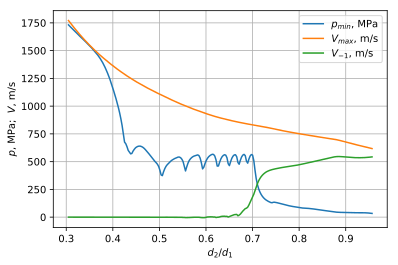

In [94]:
%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (6,4) 

r = ress[50:]

xs = [d['x']['D2_D1'] for d in r]

ys = [-d['result']['p_min']/1e6 for d in r]
plt.plot(xs, ys, label='$p_{min}$, MPa')

# ys = [d['result']['p_max']/1e6 for d in r]
# plt.plot(xs, ys, label='$p_{max}$, MPa')

ys = [d['result']['v_max'] for d in r]
plt.plot(xs, ys, label='$V_{max}$, m/s')

ys = [d['result']['v_-1'] for d in r]
plt.plot(xs, ys, label='$V_{-1}$, m/s')

plt.xlabel('$d_2/d_1$')
plt.ylabel('$p$, MPa;  $V$, m/s')
plt.grid()
plt.legend()
plt.savefig('d_0_23mm__V_0_576m_s__L_pist_70mm.png', dpi=300,bbox_inches='tight')

In [79]:
def get_x_dict2(v0):
    alpha = atan((23-16)/200)
    result = dict(M=v0/2308, D2_D1=16/23, L_D1=100/23,L_pist_D1=70/23)
    return result
pl1 = [get_x_dict2(v0) for v0 in np.linspace(50,570,50)]  

In [80]:
rezs = cl.map(get_result, pl1)
progress(rezs)

VBox()

In [81]:
ress = cl.gather(rezs)

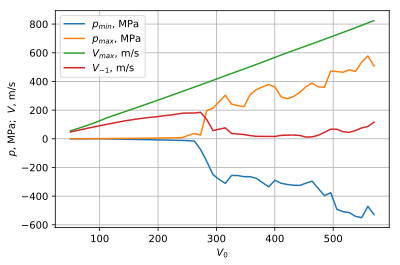

In [82]:
%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (6,4) 

xs = [d['x']['M']*2308 for d in ress]
ys = [d['result']['p_min']/1e6 for d in ress]
plt.plot(xs, ys, label='$p_{min}$, MPa')
ys = [d['result']['p_max']/1e6 for d in ress]

plt.plot(xs, ys, label='$p_{max}$, MPa')
ys = [d['result']['v_max'] for d in ress]
plt.plot(xs, ys, label='$V_{max}$, m/s')
plt.xlabel('$V_0$')
plt.ylabel('$p$, MPa;  $V$, m/s')

ys = [d['result']['v_-1'] for d in ress]
plt.plot(xs, ys, label='$V_{-1}$, m/s')
plt.grid()
plt.legend()
plt.savefig('d_0_23mm__V_0_576m_s__L_pist_70mm.png', dpi=300,bbox_inches='tight')

In [13]:
futs = [cl.submit(get_result, x_sample,pure=False) for i in range(140)]
cl.gather(futs)

[{'x': {'D_1': 23, 'D2_D1': 0.5, 'L_D1': 5, 'L_pist_D1': 4, 'M': 0.5},
  'result': {'p_max': 1462225587.1076722,
   'p_min': -300555980.07359445,
   'v_max': 2462.834922364401,
   'e_kin_max': 14176.38546134896,
   'e_kin_0': 23390.779290353465}},
 {'x': {'D_1': 23, 'D2_D1': 0.5, 'L_D1': 5, 'L_pist_D1': 4, 'M': 0.5},
  'result': {'p_max': 1462225587.1076722,
   'p_min': -300555980.07359445,
   'v_max': 2462.834922364401,
   'e_kin_max': 14176.38546134896,
   'e_kin_0': 23390.779290353465}},
 {'x': {'D_1': 23, 'D2_D1': 0.5, 'L_D1': 5, 'L_pist_D1': 4, 'M': 0.5},
  'result': {'p_max': 1462225587.1076722,
   'p_min': -300555980.07359445,
   'v_max': 2462.834922364401,
   'e_kin_max': 14176.38546134896,
   'e_kin_0': 23390.779290353465}},
 {'x': {'D_1': 23, 'D2_D1': 0.5, 'L_D1': 5, 'L_pist_D1': 4, 'M': 0.5},
  'result': {'p_max': 1462225587.1076722,
   'p_min': -300555980.07359445,
   'v_max': 2462.834922364401,
   'e_kin_max': 14176.38546134896,
   'e_kin_0': 23390.779290353465}},
 {'x': {

In [15]:
from planner import Planner

In [16]:
planner = Planner('results.db')

In [17]:
def get_plan():
    import pprint
    from copy import deepcopy
    from itertools import product
    diaps = {
        'D_1': np.linspace(23,69,3), #мм
        'D2_D1': np.linspace(0.05, 0.9, 18), # отношение
        'L_D1': np.linspace(2,15,14), # тоже самое
        'L_pist_D1': np.linspace(2,15,14),
        'M': np.linspace(0.1, 3, 30)
    }
    pprint.pprint(diaps)
    count = 1
    for a in diaps.values():
        count *= len(a)
    print(f'count = {count}')
    return [{ k: vv for k, vv in zip(diaps.keys(), v)} for v in product(*[v for v in diaps.values()])]
        
plan = get_plan();

{'D2_D1': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ]),
 'D_1': array([23., 46., 69.]),
 'L_D1': array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15.]),
 'L_pist_D1': array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15.]),
 'M': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. ])}
count = 317520


In [85]:
dd = {  'D_1': np.linspace(23,69,3), #мм
        'D2_D1': np.linspace(0.05, 0.9, 3),
         'L_D1': np.linspace(2,10,3)}
[{ k: vv for k, vv in zip(dd.keys(), v)} for v in product(*[v for v in dd.values()])]

[{'D_1': 23.0, 'D2_D1': 0.05, 'L_D1': 2.0},
 {'D_1': 23.0, 'D2_D1': 0.05, 'L_D1': 6.0},
 {'D_1': 23.0, 'D2_D1': 0.05, 'L_D1': 10.0},
 {'D_1': 23.0, 'D2_D1': 0.475, 'L_D1': 2.0},
 {'D_1': 23.0, 'D2_D1': 0.475, 'L_D1': 6.0},
 {'D_1': 23.0, 'D2_D1': 0.475, 'L_D1': 10.0},
 {'D_1': 23.0, 'D2_D1': 0.9, 'L_D1': 2.0},
 {'D_1': 23.0, 'D2_D1': 0.9, 'L_D1': 6.0},
 {'D_1': 23.0, 'D2_D1': 0.9, 'L_D1': 10.0},
 {'D_1': 46.0, 'D2_D1': 0.05, 'L_D1': 2.0},
 {'D_1': 46.0, 'D2_D1': 0.05, 'L_D1': 6.0},
 {'D_1': 46.0, 'D2_D1': 0.05, 'L_D1': 10.0},
 {'D_1': 46.0, 'D2_D1': 0.475, 'L_D1': 2.0},
 {'D_1': 46.0, 'D2_D1': 0.475, 'L_D1': 6.0},
 {'D_1': 46.0, 'D2_D1': 0.475, 'L_D1': 10.0},
 {'D_1': 46.0, 'D2_D1': 0.9, 'L_D1': 2.0},
 {'D_1': 46.0, 'D2_D1': 0.9, 'L_D1': 6.0},
 {'D_1': 46.0, 'D2_D1': 0.9, 'L_D1': 10.0},
 {'D_1': 69.0, 'D2_D1': 0.05, 'L_D1': 2.0},
 {'D_1': 69.0, 'D2_D1': 0.05, 'L_D1': 6.0},
 {'D_1': 69.0, 'D2_D1': 0.05, 'L_D1': 10.0},
 {'D_1': 69.0, 'D2_D1': 0.475, 'L_D1': 2.0},
 {'D_1': 69.0, 'D2_D1': 

In [14]:
planner.set_plan(plan)

NameError: name 'planner' is not defined

In [18]:
uncalced = planner.get_uncalced()

In [19]:
for id, x in uncalced:
    x['id'] = id
uncalced[0]

('120625',
 {'D_1': 46.0,
  'D2_D1': 0.15,
  'L_D1': 9.0,
  'L_pist_D1': 4.0,
  'M': 2.6,
  'id': '120625'})

In [20]:
results_plan = [cl.submit(get_result, x) for id, x in uncalced]

In [21]:
from dask.distributed import progress

In [22]:
progress(results_plan)

VBox()

In [23]:
results_plan[0].result()

{'x': {'D_1': 46.0,
  'D2_D1': 0.15,
  'L_D1': 9.0,
  'L_pist_D1': 4.0,
  'M': 2.6,
  'id': '120625'},
 'result': {'p_max': 288692548030.4024,
  'p_min': -304053839.95299053,
  'v_max': 14386.329438127703,
  'e_kin_max': 322561.68671047,
  'e_kin_0': 632486.6720111577}}

In [24]:
import csv

results_g = cl.gather(results_plan)

with open('results3.csv', 'w', newline='') as f:
    r0 = results_plan[0].result()
    fieldnames = ['#'] + list(r0['x']) + list(r0['result'])
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for i, ri in enumerate(tqdm_notebook(results_g)):
        d = {'#': i}
        for k in ri['x']:
            d[k] = ri['x'][k]
        for k in ri['result']:
            d[k] = ri['result'][k]
        writer.writerow(d)

In [25]:
results_g[0]

{'x': {'D_1': 46.0,
  'D2_D1': 0.15,
  'L_D1': 9.0,
  'L_pist_D1': 4.0,
  'M': 2.6,
  'id': '120625'},
 'result': {'p_max': 288692548030.4024,
  'p_min': -304053839.95299053,
  'v_max': 14386.329438127703,
  'e_kin_max': 322561.68671047,
  'e_kin_0': 632486.6720111577}}